In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
pd.options.display.max_colwidth = -1

%matplotlib inline

In [2]:
# look at distrubution in number of categories over test and train

def num_cats(text):
    try:
        return len(text.split('/'))
    except:
        return 0
    
def split_cat(text):
    try:
        split = text.split('/')
        if len(split) == 3:
            split.extend(["only 3 labels", "only 3 labels"])
        elif len(split) == 4:
            split.extend(["only 4 labels"]) 
        return split
    except:
        # choosing np.nan enables a get_dummies option to ignore / include missing values
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    
def print_horiz_line():
    print("-----------------------")

In [3]:
train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/test.tsv', sep='\t')

# size of data

print("Size of data:")
print("train, {}".format(train.shape))
print("test, {}".format(test.shape))

Size of data:
train, (1482535, 8)
test, (693359, 7)


In [4]:
train['num_cats'] = train['category_name'].apply(lambda x: num_cats(x))
test['num_cats'] = train['category_name'].apply(lambda x: num_cats(x))

print("Training distribution")
print(train.num_cats.value_counts())
print("Testing distribution")
print(test.num_cats.value_counts())

Training distribution
3    1471819
0    6327   
5    3059   
4    1330   
Name: num_cats, dtype: int64
Testing distribution
3    688370
0    2967  
5    1409  
4    613   
Name: num_cats, dtype: int64


In [5]:
train['general_cat'], train['sub_cat1'], train['sub_cat2'], train['sub_cat3'], train['sub_cat4'] =\
    zip(*train['category_name'].apply(lambda x: split_cat(x)))
    
test['general_cat'], test['sub_cat1'], test['sub_cat2'], test['sub_cat3'], test['sub_cat4'] = \
    zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [9]:
# # sanity check
train.loc[train.num_cats==4, ['category_name', 'general_cat', 'sub_cat1', 
                              'sub_cat2', 'sub_cat3', 'sub_cat4']].sample(1)

# # sanity check
# train.loc[train.num_cats==5, ['category_name', 'general_cat', 'sub_cat1', 
#                               'sub_cat2', 'sub_cat3', 'sub_cat4']].sample(1)

# # sanity check
# train.loc[train.num_cats==3, ['category_name', 'general_cat', 'sub_cat1',
#                               'sub_cat2', 'sub_cat3', 'sub_cat4']].sample(1)

# # sanity check
# train.loc[train.num_cats==0, ['category_name', 'general_cat', 'sub_cat1',
#                               'sub_cat2', 'sub_cat3', 'sub_cat4']].sample(1)

,category_name,general_cat,sub_cat1,sub_cat2,sub_cat3,sub_cat4
1449889,Sports & Outdoors/Outdoors/Indoor/Outdoor Games,Sports & Outdoors,Outdoors,Indoor,Outdoor Games,only 4 labels


In [10]:
def print_train_test_diff(train, test, column):
    num_examples = 10
    
    print("Training and testing differences in column {}"
         .format(column))
    unique_train = set(train.loc[:, column].unique())
    unique_test = set(test.loc[:, column].unique())
    unique_total = unique_train.union(unique_test)
    print("Number of unique categories, {}"
         .format(len(unique_total)))
    print("Number of unique training categories, {}"
         .format(len(unique_train)))
    print("Number of unique testing categories, {}"
         .format(len(unique_test)))
    print("Number of training categories not in test, {}"
         .format(len(unique_train.difference(unique_test))))
    if len(unique_train.difference(unique_test)) > 0:
        print("... some examples are: {}"
             .format(", ".join(list(unique_train.difference(unique_test))[:num_examples])))
    print("Number of test categories not in training, {}"
         .format(len(unique_test.difference(unique_train))))
    if len(unique_test.difference(unique_train)) > 0:
        print("... some examples are: {}"
             .format(", ".join(list(unique_test.difference(unique_train))[:num_examples])))
    print("Size of intersection, {}"
         .format(len(unique_test.intersection(unique_train))))
    print_horiz_line()

print_train_test_diff(train, test, 'general_cat')
print_train_test_diff(train, test, 'sub_cat1')
print_train_test_diff(train, test, 'sub_cat2')
print_train_test_diff(train, test, 'sub_cat3')
print_train_test_diff(train, test, 'sub_cat4')
print_train_test_diff(train, test, 'brand_name')

Training and testing differences in column general_cat
Number of unique categories, 11
Number of unique training categories, 11
Number of unique testing categories, 11
Number of training categories not in test, 0
Number of test categories not in training, 0
Size of intersection, 11
-----------------------
Training and testing differences in column sub_cat1
Number of unique categories, 114
Number of unique training categories, 114
Number of unique testing categories, 114
Number of training categories not in test, 0
Number of test categories not in training, 0
Size of intersection, 114
-----------------------
Training and testing differences in column sub_cat2
Number of unique categories, 883
Number of unique training categories, 871
Number of unique testing categories, 834
Number of training categories not in test, 49
... some examples are: Fireplaces & Accessories, Holiday Décor Storage, Competitive Swimwear, Safety Caps, Child Friendly, House, Towel, Crib Netting, Coasters, Animals
Nu

In [ ]:
def print_column_info(df, column, num_top, num_bot=None):
    print("Top {} value counts:\n{}\n"
          .format(num_top, df[column].value_counts().iloc[:num_top]))
    if num_bot is not None:
        print("Bottom {} value counts:\n{}\n"
             .format(num_bot, df[column].value_counts().iloc[-num_bot:]))

In [ ]:
print("Train data, general_cat info")
print_column_info(train, 'general_cat', 11)
print("Test data, general_cat info")
print_column_info(test, 'general_cat', 11)
print_horiz_line()

print("Train data, sub category 1 info")
print_column_info(train, 'sub_cat1', 10, 10)
print("Test data, sub category 1 info")
print_column_info(test, 'sub_cat1', 10, 10)
print_horiz_line()

print("Train data, sub category 2 info")
print_column_info(train, 'sub_cat2', 10, 10)
print("Test data, sub category 2 info")
print_column_info(test, 'sub_cat2', 10, 10)
print_horiz_line()

print("Train data, sub category 3 info")
print_column_info(train, 'sub_cat3', 10)
print("Test data, sub category 3 info")
print_column_info(test, 'sub_cat3', 10)
print_horiz_line()

print("Train data, sub category 4 info")
print_column_info(train, 'sub_cat4', 10)
print("Test data, sub category 4 info")
print_column_info(test, 'sub_cat4', 10)
print_horiz_line()

In [31]:
def plot_column_dist(train, test, column):
    data = pd.concat([train, test], axis=0)
    train_name = 'train_' + column
    test_name = 'test_' + column
    train_counts = train[column].value_counts()
    test_counts = test[column].value_counts()
    train_counts.name = train_name
    test_counts.name = test_name
    merged = pd.concat([train_counts, test_counts], axis=1).fillna(0)
    merged.sort_values(train_name, inplace=True, ascending=False)
    
    N = len(merged)
    ind = np.arange(N)
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(ind, merged[train_name].values, width, color='r')
    ax.bar(ind + width, merged[test_name].values, width, color='y')

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(merged.index, rotation='vertical')
    return ax

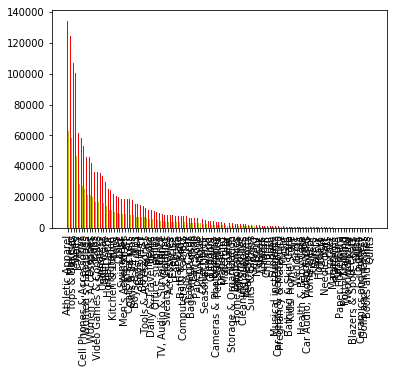

In [32]:
plot_column_dist(train, test, 'su')

In [ ]:
all_data = pd.concat([train, test], axis=0)

In [ ]:
test.head(1)

In [ ]:
train.head(1)

In [ ]:
all_data.loc[all_data['general_cat'].isnull()].head(1)

In [4]:
def reshape_onehot(train, test, column, prefix='_', dummy_na=False,
                   rel_thresh=1, only_rel_cols=True, verbose=False):
    all_data = pd.concat([train, test], axis=0)

    if only_rel_cols:
        train_counts = train[column].value_counts()
        
        # these are good categories to train on
        thresh_train = set(train_counts.loc[train_counts >= rel_thresh].index)
        
        if verbose:
            print("{} of {} values pass threshold of {}"
                  .format(len(thresh_train), len(train_counts), rel_thresh))
            
        all_data.loc[~all_data[column].isin(thresh_train), column] = np.nan
    new_columns = pd.get_dummies(all_data[column], prefix=prefix,
                                 dummy_na=dummy_na)
    new_data = pd.concat([all_data.drop([column], axis=1), new_columns],
                         axis=1)
    new_train = new_data.loc[new_data.test_id.isnull()].drop(['test_id'],
                                                             axis=1)
    new_test = new_data.loc[new_data.train_id.isnull()].drop(['train_id'],
                                                             axis=1)
    return new_train, new_test

In [5]:
train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/test.tsv', sep='\t')

train['general_cat'], train['sub_cat1'], train['sub_cat2'], train['sub_cat3'], train['sub_cat4'] =\
    zip(*train['category_name'].apply(lambda x: split_cat(x)))
    
test['general_cat'], test['sub_cat1'], test['sub_cat2'], test['sub_cat3'], test['sub_cat4'] = \
    zip(*test['category_name'].apply(lambda x: split_cat(x)))

train, test = reshape_onehot(train, test, 'brand_name', prefix='bn', rel_thresh=20, verbose=True)
# train, test = reshape_onehot(train, test, 'general_cat', prefix='cat0')
# train, test = reshape_onehot(train, test, 'sub_cat1', prefix='cat1')
# train, test = reshape_onehot(train, test, 'sub_cat2', prefix='cat2')
# train, test = reshape_onehot(train, test, 'sub_cat3', prefix='cat3')
# train, test = reshape_onehot(train, test, 'sub_cat4', prefix='cat4')

1280 of 4809 values pass threshold of 20


In [ ]:
train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/test.tsv', sep='\t')

In [61]:
rel_thresh = 5
column = 'brand_name'
train_counts = train[column].value_counts()
thresh_train = set(train_counts.loc[train_counts >= rel_thresh].index)
len(train_counts.loc[train_counts >= rel_thresh].index)

2390

In [6]:
train.head(1)

,category_name,general_cat,item_condition_id,item_description,name,price,shipping,sub_cat1,sub_cat2,sub_cat3,...,bn_moms,bn_patagonia,bn_pet brands,bn_prAna,bn_rag & bone,bn_rue,bn_theBalm,bn_tokidoki,bn_totes ISOTONER,bn_vineyard vines
0,Men/Tops/T-shirts,Men,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,10.0,1,Tops,T-shirts,only 3 labels,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
column = 'general_cat'
a = train[column].value_counts()
a.loc[a > 30000].index
train[column].value_counts()
len(a)